In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
import pingouin as pg
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')
import pandahouse as ph

import plotly.graph_objects as go
from plotly.subplots import make_subplots

Файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)

In [2]:
groups = pd.read_csv('groups.csv', sep=';')

Файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента


In [3]:
active_studs = pd.read_csv('active_studs.csv')

Файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [4]:
checks = pd.read_csv('checks.csv', sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Переименуем столбцы id в данных у groups в student_id, для облегчения работы в дальнейшнем

In [5]:
groups = groups.rename(columns={'id': 'student_id'})

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Проверим какой части пользователей показалась страница оплаты

In [6]:
active_studs.merge(groups, on='student_id', how='inner').count()

student_id    8328
grp           8328
dtype: int64

Проверим сколько было оплат из активных пользователей

In [7]:
active_studs.merge(checks, on='student_id', how='inner').count()

student_id    392
rev           392
dtype: int64

Проверим сколько было оплат пользователей с расставленной группой эксперимента

In [8]:
groups.merge(checks, on='student_id', how='inner').count()

student_id    540
grp           540
rev           540
dtype: int64

In [9]:
groups

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74479,5692459,B
74480,5692572,B
74481,5692865,B
74482,5693667,B


Получается, что не все пользотели зашли на сайт, но при этом часть пользователей оплачивали не заходя на сайт (либо долетели старые оплаты).

Сделаем датасет только с активными пользователями и добавим оплаты.

In [10]:
active = groups.merge(active_studs, on='student_id', how='inner') \
               .merge(checks, on='student_id', how = 'left') \
               .fillna(0)

Также добавим факт покупки - для вычисления показателей.

In [11]:
active['purch'] = active.rev.apply(lambda x: 1 if x > 0 else 0)
active.head()

,student_id,grp,rev,purch
0,1627,A,990.0,1
1,2085,B,0.0,0
2,2215,B,0.0,0
3,3391,A,0.0,0
4,3401,B,0.0,0


Зададим датасеты для пользователей с покупками.

In [12]:
active_purch_a = active.query('grp == "A" & rev > 0')
active_purch_b = active.query('grp == "B" & rev > 0')
active_purch = active.query('rev > 0')

In [13]:
active_purch

,student_id,grp,rev,purch
0,1627,A,990.0000,1
10,100300,B,990.0000,1
12,108270,B,290.0000,1
246,264473,B,1900.0001,1
279,274352,B,690.0000,1
...,...,...,...,...
8299,5609523,B,1900.0000,1
8312,5645737,B,1900.0000,1
8314,5651566,B,1900.0000,1
8316,5662322,B,1900.0000,1


Поищем аномалии покупок.

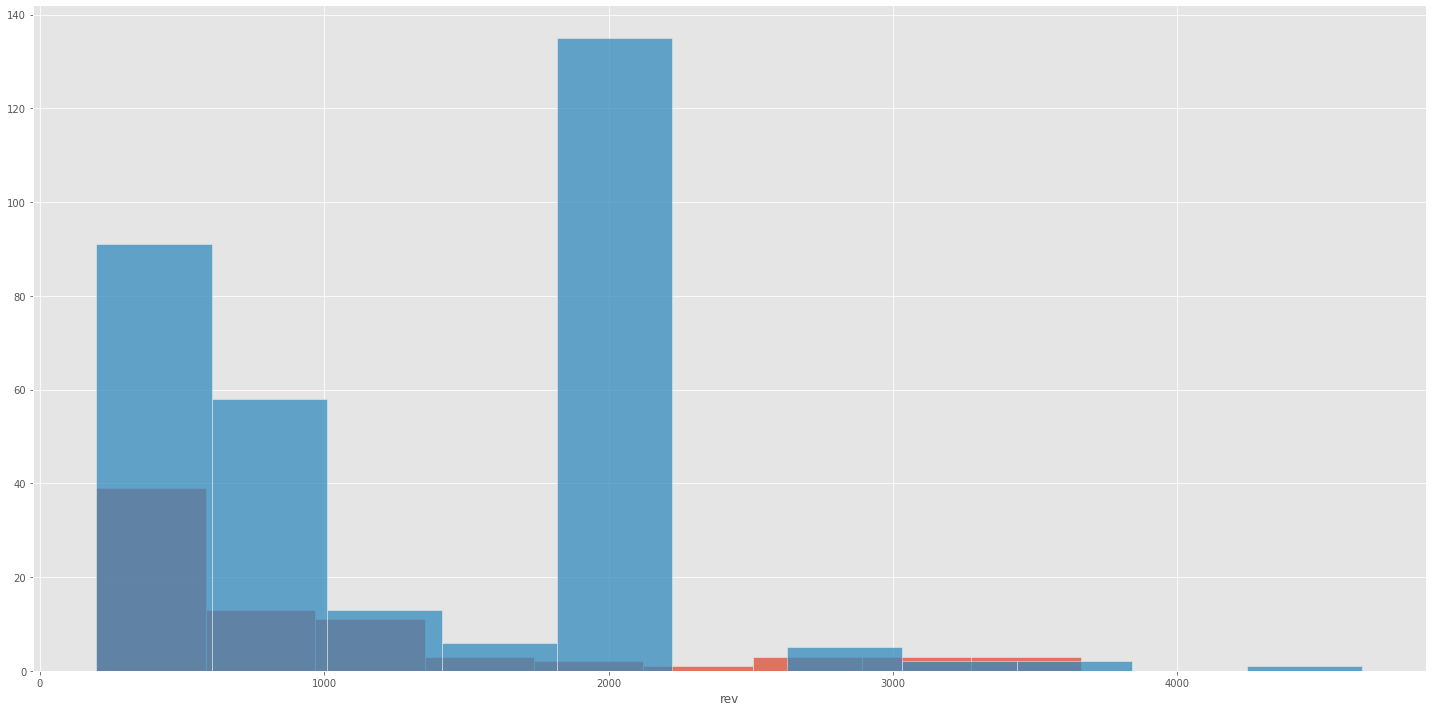

In [14]:
g = sns.FacetGrid(active_purch, height=10, aspect=2, hue='grp')
g.map(sns.histplot, "rev")

Есть явный выброс в целевой группе (B), распределения не нормальны визуально, репрезентативность визуально одинаковая, кроме выброса около 1900.

In [15]:
active_purch_b.rev.value_counts().head(5)

1900.0000    92
290.0000     45
1900.0001    35
199.0000     27
840.0000     21
Name: rev, dtype: int64

Исклюим из датасета 1900 и 1900.0001, что бы проанализировать датасет без выброса.

Проверим его наравне с обычным датасетом в последующем.

In [16]:
active_1900 = active[active['rev'] != 1900.0001]
active_1900 = active[active['rev'] != 1900]

Сделаем проверку обоих датесетов через Шапиро - проверяем что выборка изъята из генеральной совокупности, где распределение нормальное.

Сначала для полного датасета.

In [17]:
a = stats.shapiro(active_purch_a.student_id)
b = stats.shapiro(active_purch_b.student_id)

print('Для контрольной группы P =', a[1])
print('Для целевой группы P =', b[1])

Для контрольной группы P = 0.001170420553535223
Для целевой группы P = 4.214313342743026e-09


P_value меньше 5% для обеих групп, значит распределния не нормальны.

Для датасета без 1900.

In [18]:
active_purch_a_1900 = active_1900.query('grp == "A" & rev > 0')
active_purch_b_1900 = active_1900.query('grp == "B" & rev > 0')
active_purch_1900 = active_1900.query('rev > 0')
a = stats.shapiro(active_purch_a_1900.student_id)
b = stats.shapiro(active_purch_b_1900.student_id)

print('Для контрольной группы P =', a[1])
print('Для целевой группы P =', b[1])

Для контрольной группы P = 0.001170420553535223
Для целевой группы P = 6.756736752322468e-07


P_value также меньше 5% для обеиз группы, значит распределния не нормальны.

Наше распределенние не нормально, а так же выборки разные по размеру - значит нам не подойдет Т-тест.

Манн-Уитни также не подойдет - он переводит все значения в ранговую шкалу и из-зза одинаковых значений ранг будут не уникальны.

Значит остается бутстрап, который может проводить проверку для любого распределения и для любого количества значений.

# Рассчет метрик
CR - конверсия в покупку.

ARPU - доход на одного пользователя (он же средний чек, тк на одного пользователя одна покупка).

ARPPU - доход на одного платящего.

In [19]:
metrics = active.groupby('grp', as_index=False).agg({'student_id': 'count', 'purch': 'sum', 'rev': 'sum'}) \
                .rename(columns={'student_id': 'num'})
metrics['cr'] = round(metrics['purch'] / metrics['num'] * 100, 2)
metrics['arpu'] = round(metrics['rev'] / metrics['num'], 2)
metrics['arppu'] = round(metrics['rev'] / metrics['purch'], 2)
metrics

,grp,num,purch,rev,cr,arpu,arppu
0,A,1535,78,72820.0000,5.08,47.44,933.59
1,B,6793,313,393074.0035,4.61,57.86,1255.83


1 - CR упал

2 - Зато выросла выручка, ARPU и ARRPU

Посчитаем метрике для датасета с покупками не больше 1900 р.

In [20]:
metrics_1900 = active_1900.groupby('grp', as_index=False).agg({'student_id': 'count', 'purch': 'sum', 'rev': 'sum'}) \
                          .rename(columns={'student_id': 'num'})
metrics_1900['cr'] = round(metrics_1900['purch'] / metrics_1900['num'] * 100, 2)
metrics_1900['arpu'] = round(metrics_1900['rev'] / metrics_1900['num'], 2)
metrics_1900['arppu'] = round(metrics_1900['rev'] / metrics_1900['purch'], 2)
metrics_1900

,grp,num,purch,rev,cr,arpu,arppu
0,A,1535,78,72820.0000,5.08,47.44,933.59
1,B,6701,221,218274.0035,3.30,32.57,987.67


Для датасета с чекам меньше 1900 различия в группах уже другие:

1 - CR сильно отличается.

2 - ARPU также значительно просел.

3 - А вот ARPPU уже с меньшим разницей.

Также заметим, что размеры групп сильно отличаются друг от друга, в обоих вариантах

Но это не означает, что сплитование сделано плохо, так как репрезентативность значений в выборке одинакова.

# Стат тесты

### Для CR воспольуземся Хи-квадрат, так как покупка это категориальная переменная (купил / некупил).

#### Сначала для общего датасета.

In [22]:
cros = pd.crosstab(active['grp'], active['purch'])
cros

purch,0,1
grp,,
A,1457,78
B,6480,313


In [23]:
chi2, p, dof, ex = stats.chi2_contingency(cros,correction=False)

round(p, 2)

0.43

P_value больше 5%, значит принять альтернативную гипотезу не можем - стат. значимых отличий нет

#### Теперь посчитаем для датасета без чеков на 1900.

In [24]:
cros_1900 = pd.crosstab(active_1900['grp'], active_1900['purch'])
cros_1900

purch,0,1
grp,,
A,1457,78
B,6480,221


#### Хи квадрат

In [25]:
chi2, p, dof, ex = stats.chi2_contingency(cros_1900,correction=False)
p

0.0007529182537820297

P_value меньше 5%, значит можем альтернативную гипотезу - стат. значимые отличия есть.

### Теперь сделаем бутстрап для вычисления значимости среднего дохода.

Для начала зададим саму функцию.

In [26]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

#### Зададим датафреймы для каждой группы в общем датасете

In [27]:
active_a = active[active['grp'] == 'A']
active_b = active[active['grp'] == 'B']

Считаем для среднего дохода

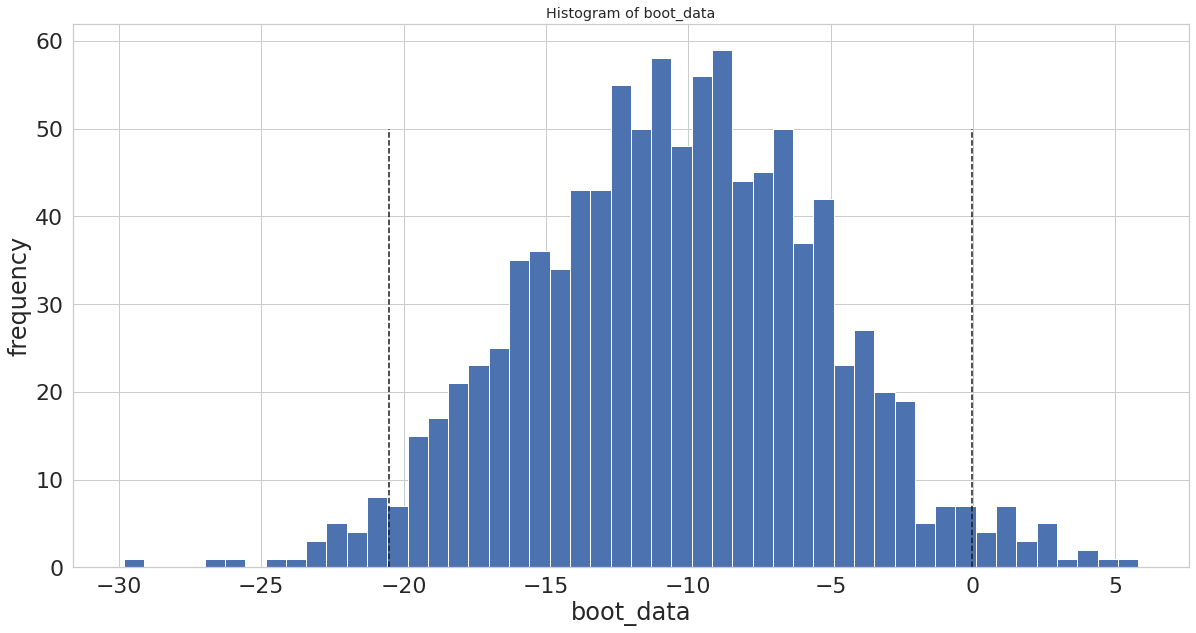

In [28]:
booted_data = get_bootstrap(active_a.rev, active_b.rev, statistic = np.mean)

In [29]:
print('p_value = ', booted_data["p_value"])
print('\n')
print('ci = ', booted_data["ci"])

p_value =  0.043816948694976925


ci =                 0
0.025 -20.513441
0.975  -0.025538


P_value меньше 5%, значит можем отклонить Нулевую гипотезу о равенстве средних чеков.

#### Теперь сделаем бутстрап для датасета без чеков на 1900.

Зададим датафреймы для каждой группы.

In [30]:
active_1900_a = active_1900[active_1900['grp'] == 'A']
active_1900_b = active_1900[active_1900['grp'] == 'B']

Бутстрап для среднего дохода

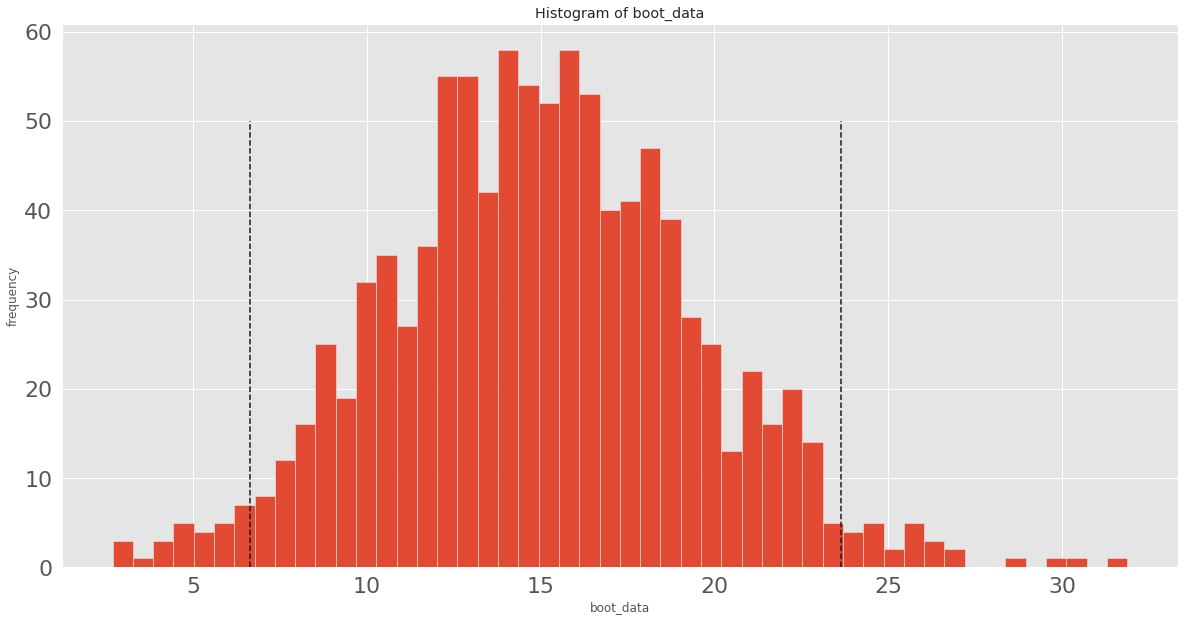

In [46]:
booted_data = get_bootstrap(active_1900_a.rev, active_1900_b.rev, statistic = np.mean)

In [47]:
print('p_value = ', booted_data["p_value"])
print('\n')
print('ci = ', booted_data["ci"])

p_value =  0.000645477412126724


ci =                 0
0.025   6.636091
0.975  23.634263


P_value меньше 5%, значит можем отклонить Нулевую гипотезу о равенстве средних чеков.

In [33]:
metrics

,grp,num,purch,rev,cr,arpu,arppu
0,A,1535,78,72820.0000,5.08,47.44,933.59
1,B,6793,313,393074.0035,4.61,57.86,1255.83


In [34]:
metrics_1900

,grp,num,purch,rev,cr,arpu,arppu
0,A,1535,78,72820.0000,5.08,47.44,933.59
1,B,6701,221,218274.0035,3.30,32.57,987.67


Так же сохраним файл метрик с полными данными в файл для дальнейшего использования

In [35]:
metrics.to_csv('metrics.csv', index = False)

# Выводы

Мы проанализировали датасет и нашли в нем выбросы на 1900 и 1900.0001.

Такие значения могут говорить о двух вещах:
- Либо это "фича", в виде, к примеру, всплывающей плашки со скидкой
- Либо это запущенная акция другим продактом, без согласования с лидами эксперимента

Что бы проверить оба варианта мы сделали два датасета (полный и без выбросов) и проанализировали оба.
- Для полного варианта результаты АБ-теста говорят о том, что изменения позволяют достичь больших значений по выручке. Также это подтверждает бутстрап, который говорит что средние чеки статистически не равны между собой, а значит мы можем раскатывать обновление на всех пользователей.
- Для обрезанного датасета ситуация иная - чеки около 1900 забрали треть покупок и CR меньше еще сильнее по сравнению с контрольной группой. Также средний чек стал очень мал, и при выкате эксперимента на прод мы увидим сильное падение в выручке.

Поэтому, перед подведением итогов необходимо проконсультироваться с продактами, в чем именно были изменения.

Если сделать выводу с имеющимися данными, то можно сказать что эксперимент плохо повлиял на конверсию в покупку. Рост среднего чека может быть обсуловлен акцией, о которой мы не знаем и тут сложно судить.

Так как изначальные условия были про изменение механики оплаты, то мы должны были увидеть изменения в CR - они есть и в худшую сторону. 

### Поэтому выкатывать на всех пользователей новые изменения не стоит.

# Задание 2

## 2.1
Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.

In [36]:
# создаем подключение для SQL
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [37]:
# проверяем какие месяцы есть в базе
query = """
SELECT DISTINCT toStartOfMonth(timest)
FROM default.peas
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,toStartOfMonth(timest)
0,2021-10-01


Так как все результаты лежат за один месяц, то запрос не будет учитывать дату.

In [38]:
query = """
SELECT count(st_id) AS num
FROM (
    SELECT st_id, SUM(correct) AS count_peas
    FROM default.peas
    GROUP BY st_id
    HAVING count_peas >= 20
    )
"""
df = ph.read_clickhouse(query, connection=connection_default)
print('Количество очень усердных студентов =', df['num'][0])

Количество очень усердных студентов = 136


## 2.2
Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

In [39]:
query = """
    SELECT 
        cs.test_grp AS test_grp, -- Группа пользователя
        SUM(ms.all_money) / count(cs.st_id) AS ARPU,
        sumIf(ms.all_money, act_s.all_active > 10) / countIf(cs.st_id, act_s.all_active > 10) AS ARPAU,
        countIf(cs.st_id, ms.all_money > 0) / (count(cs.st_id)) AS CR,
        countIf(cs.st_id, ms.all_money > 0 AND act_s.all_active > 10) / countIf(cs.st_id, act_s.all_active > 10) AS CR_ACT,
        countIf(cs.st_id, ms.math_money > 0 AND act_s.math_active > 2) / countIf(cs.st_id, act_s.math_active > 2) AS CR_ACT_MATH
    FROM (-- Уникальные идентификаторы студентов и группы
        SELECT test_grp, st_id
        FROM default.studs) AS cs
    LEFT JOIN (-- Считаем активности
        SELECT 
            st_id, 
            count(st_id) AS all_active,
            countIf(st_id, subject = 'Math') as math_active
        FROM default.peas
        WHERE correct = 1
        GROUP BY st_id
        ) AS act_s ON cs.st_id = act_s.st_id
    LEFT JOIN (-- Считаем деньги
        SELECT
            st_id,
            sumIf(money, subject = 'Math') as math_money, 
            sum(money) as all_money
        FROM default.final_project_check
        GROUP BY st_id) AS ms ON cs.st_id = ms.st_id
    GROUP BY cs.test_grp
"""
df = ph.read_clickhouse(query, connection=connection_default)
df

,test_grp,ARPU,ARPAU,CR,CR_ACT,CR_ACT_MATH
0,control,4540.983607,10393.700787,0.049180,0.110236,0.061224
1,pilot,11508.474576,29739.583333,0.108475,0.260417,0.095238


# 3

## 3.1
Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

In [40]:
def get_new_metrics(group_add = 'group_add.csv',
                    groups = 'groups.csv',
                    active_studs = 'active_studs.csv',
                    checks = 'checks.csv'):
    '''Функция принимает на вход файлы с резульататами АБ-теста и рассчитывает метрики с добавленным файлом.
(groups студенты с группами,
active_studs - какие студенты были активны во время теста,
checks - оплаты студентов, во время тестаб
group_add - дополнительный файл) '''
        
    # считываем файлы новых и старых данных и сразу переименовываем столбцы
    groups = pd.read_csv(groups, sep=';', names=['student_id', 'grp'], header=0)
    group_add = pd.read_csv(group_add, sep=',', names=['student_id', 'grp'], header=0)
    
    # также считаем данные active_studs и checks
    active_studs = pd.read_csv(active_studs)
    checks = pd.read_csv(checks, sep=';')
    
    # склеиваем данные
    groups_new = pd.concat([groups, group_add])

    # сделаем датасет только с активными пользователями и добавим оплаты
    active_new = groups_new.merge(active_studs, on='student_id', how='inner') \
                          .merge(checks, on='student_id', how = 'left') \
                          .fillna(0)

    # добавим метрику покупки
    active_new['purch'] = active_new.rev.apply(lambda x: 1 if x > 0 else 0)

    # рассчет метрик
    metrics_new = active_new.groupby('grp', as_index=False) \
                            .agg({'student_id': 'count', 'purch': 'sum', 'rev': 'sum'}) \
                            .rename(columns={'student_id': 'num'})
    metrics_new['cr'] = round(metrics_new['purch'] / metrics_new['num'] * 100, 2)
    metrics_new['arpu'] = round(metrics_new['rev'] / metrics_new['num'], 2)
    metrics_new['arppu'] = round(metrics_new['rev'] / metrics_new['purch'], 2)
    
    # сохраняем файл на диск
    return metrics_new.to_csv('metrics_new.csv')

In [41]:
get_new_metrics()

# 3.2
Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [42]:
def get_chart(metrics_new = 'metrics_new.csv',
              metrics_prev = 'metrics.csv'):
    '''Функция принимает на вход два файла с метриками:
с оригинальным файлом и с учетом дополнительного и рисует график с изменением метрик.
Также можно нарисовать для более двух файлов, если к примеру будет прислан еще один файл.
В таком случае понадобится файл с последними изменениями.'''
    
    # file_new - файл с новыми пользователями, по умолчанию как в задании
    # metrics_prev - файл с метриками, по умолчанию из предыдущих вычислений
    
    # получаем файл с новыми метриками с диска
    metrics_new = pd.read_csv(metrics_new)
    
    # получаем файл со старыми метриками с диска
    metrics_prev = pd.read_csv(metrics_prev)

    # добавим колонку с номером загрузки датасета для первого датасета
    # перед этим проверив есть ли в этой колонке что-либо, для случаев, когда уже был создана колонка
    # если нет колонки, то добавляем ее
    if ('part' in metrics_prev.columns) == False:
            metrics_prev['part'] = 1

    # добавим в дополнительный файл метрик колонку с номером загрузки (отталкиваемся от максимального номера загрузки)
    metrics_new['part'] = metrics_prev['part'].max() + 1

    # соединим датасеты с метриками
    metrics_fin = pd.concat([metrics_prev, metrics_new]).reset_index(drop=True)
    
    # рисуем
    fig, axes = plt.subplots(1, 3, figsize=(23,7))

    sns.lineplot(data = metrics_fin, x='part', y='cr', hue='grp', ax=axes[0])
    axes[0].set_title('CR')

    sns.lineplot(data = metrics_fin, x='part', y='arpu', hue='grp', ax=axes[1])
    axes[1].set_title('ARPU')
    
    sns.lineplot(data = metrics_fin, x='part', y='arppu', hue='grp', ax=axes[2])
    axes[2].set_title('ARPPU')
    
    return

In [43]:
print(get_chart.__doc__)

Функция принимает на вход два файла с метриками:
с оригинальным файлом и с учетом дополнительного и рисует график с изменением метрик.
Также можно нарисовать для более двух файлов, если к примеру будет прислан еще один файл.
В таком случае понадобится файл с последними изменениями.
